## import libraries

In [1]:
import glob
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import calendar

In [2]:
import unicodedata
import re
import nltk
#import inflect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

from os import listdir

filepaths = [f for f in listdir("./data") if f.endswith('.csv')]
df = pd.concat(map(pd.read_csv, filepaths))

OR

df = pd.concat(map(pd.read_csv, ['data/d1.csv', 'data/d2.csv','data/d3.csv']))

## import data

In [5]:
df_all = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')))

In [6]:
df_all.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable', 'is_starred',
       'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type'],
      dtype='object')

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213583 entries, 0 to 3679
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             213583 non-null  int64  
 1   blurb                     213576 non-null  object 
 2   category                  213583 non-null  object 
 3   converted_pledged_amount  213583 non-null  int64  
 4   country                   213583 non-null  object 
 5   country_displayable_name  213583 non-null  object 
 6   created_at                213583 non-null  int64  
 7   creator                   213583 non-null  object 
 8   currency                  213583 non-null  object 
 9   currency_symbol           213583 non-null  object 
 10  currency_trailing_code    213583 non-null  bool   
 11  current_currency          213583 non-null  object 
 12  deadline                  213583 non-null  int64  
 13  disable_communication     213583 non-null  boo

In [8]:
df_all.shape

(213583, 38)

## data preprocessing

### for null and other inapplicable columns

In [9]:
# drop columns containing with very few non-null
df = df_all.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=False)

In [10]:
# drop columns with data that already exist elsewhere in the dataset
df.drop(['profile', 'slug', 'converted_pledged_amount', 'country_displayable_name', 'pledged'], 
        axis=1, inplace=True)

In [11]:
# drop columns that contain data exclusive to a single or very few campaigns
df.drop(['creator', 'location', 'source_url', 'urls'], axis=1, inplace=True)

In [12]:
# drop columns that contain data not set up for use in this analysis
df.drop(['photo', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 
         'fx_rate', 'usd_type'], axis=1, inplace=True)

In [13]:
#drop columns which are indicated or dependent on the target
df.drop(['spotlight', 'state_changed_at'], axis=1, inplace=True)

In [14]:
# Drop disable_communication - bools are all false
df.drop('disable_communication', axis=1, inplace=True)

### for datetime columns

In [15]:
# Converting dates from unix to datetime
date_cols = ['created_at', 'deadline', 'launched_at']
for col in date_cols:
    df[[col]] = pd.to_datetime(df[col], origin='unix', unit='s')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213583 entries, 0 to 3679
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   backers_count    213583 non-null  int64         
 1   blurb            213576 non-null  object        
 2   category         213583 non-null  object        
 3   country          213583 non-null  object        
 4   created_at       213583 non-null  datetime64[ns]
 5   deadline         213583 non-null  datetime64[ns]
 6   goal             213583 non-null  float64       
 7   id               213583 non-null  int64         
 8   is_starrable     213583 non-null  bool          
 9   launched_at      213583 non-null  datetime64[ns]
 10  name             213583 non-null  object        
 11  staff_pick       213583 non-null  bool          
 12  state            213583 non-null  object        
 13  static_usd_rate  213583 non-null  float64       
 14  usd_pledged      21358

### for duplicate rows

In [17]:
#see possible duplicate rows by 'id'
df.duplicated(subset='id').sum()

25769

In [18]:
#see possible duplicate rows by 'blurb'
df.duplicated(subset='blurb').sum()

27420

In [19]:
ids = df["id"]
df[ids.isin(ids[ids.duplicated()])]

,backers_count,blurb,category,country,created_at,deadline,goal,id,is_starrable,launched_at,name,staff_pick,state,static_usd_rate,usd_pledged
2,267,Wonderful 3D Popup Christmas Cards. Opening th...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/pri...",DE,2015-10-08 07:24:00,2015-11-08 21:00:00,2500.0,1484057434,False,2015-10-16 01:09:33,"Wonderful 3D Popup Christmas Cards: Small, Yet...",True,successful,1.139062,11653.747824
3,96,Hi everyone. I love animals and I love to croc...,"{""id"":344,""name"":""Crochet"",""slug"":""crafts/croc...",CA,2019-01-14 17:46:58,2019-02-20 16:03:10,100.0,1955625514,False,2019-01-21 16:03:10,Animal Scarves to Help the Animals!,False,successful,0.754100,1641.894476
4,444,"Slim, Earth-friendly hangers with an innovativ...","{""id"":28,""name"":""Product Design"",""slug"":""desig...",US,2018-05-29 01:14:34,2020-08-22 14:56:04,7500.0,814342621,False,2020-07-13 14:56:04,Mozu Hanger - The Friendliest Hanger on the Pl...,False,successful,1.000000,26752.000000
7,3,"Introducing the Primal Conceps ""LUCILLE"" produ...","{""id"":356,""name"":""Woodworking"",""slug"":""crafts/...",US,2017-03-06 22:30:36,2017-04-12 16:13:36,100.0,1403250866,False,2017-03-13 16:13:36,Lucy Keychain bats,False,successful,1.000000,171.000000
9,32,The Seven Handmade Mechanical Models with Stea...,"{""id"":345,""name"":""DIY"",""slug"":""crafts/diy"",""po...",HK,2018-05-07 14:20:46,2018-06-14 15:31:47,15000.0,615857771,False,2018-05-15 15:31:47,The Battle Warriors of Steam Punks,False,successful,0.127389,3286.861792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3674,26,Bronwyn: The Further Adventures- Issue 1,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",AU,2020-07-09 01:30:11,2020-08-16 03:20:06,1000.0,1251772211,False,2020-07-17 03:20:06,Bronwyn- The Further Adventures- Issue 1,False,successful,0.699198,825.276829
3675,27,I have received a scholarship to the famous Br...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",GB,2016-06-28 21:11:16,2016-08-26 19:37:00,1000.0,434619322,False,2016-07-25 13:26:30,Help support me in NEW YORK!,False,successful,1.313831,1625.208737
3676,206,MONSTERS✔️ ALIENS✔️ DEMONS✔️ KILLER CLOWNS✔️ T...,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",US,2021-01-03 21:55:08,2021-03-06 05:00:00,2000.0,1262668783,False,2021-02-06 02:01:16,DEAD END #1,False,successful,1.000000,9816.000000
3677,31,Anna Reyes is a 2015 Resident Dance Artist for...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",US,2015-03-09 22:27:52,2015-06-27 03:59:00,2500.0,2037776650,False,2015-05-28 02:02:43,The Good Parts of Being Alive - Boston Center ...,True,successful,1.000000,2636.000000


In [20]:
blurbs = df["blurb"]
df[blurbs.isin(blurbs[blurbs.duplicated()])]

,backers_count,blurb,category,country,created_at,deadline,goal,id,is_starrable,launched_at,name,staff_pick,state,static_usd_rate,usd_pledged
2,267,Wonderful 3D Popup Christmas Cards. Opening th...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/pri...",DE,2015-10-08 07:24:00,2015-11-08 21:00:00,2500.0,1484057434,False,2015-10-16 01:09:33,"Wonderful 3D Popup Christmas Cards: Small, Yet...",True,successful,1.139062,11653.747824
3,96,Hi everyone. I love animals and I love to croc...,"{""id"":344,""name"":""Crochet"",""slug"":""crafts/croc...",CA,2019-01-14 17:46:58,2019-02-20 16:03:10,100.0,1955625514,False,2019-01-21 16:03:10,Animal Scarves to Help the Animals!,False,successful,0.754100,1641.894476
4,444,"Slim, Earth-friendly hangers with an innovativ...","{""id"":28,""name"":""Product Design"",""slug"":""desig...",US,2018-05-29 01:14:34,2020-08-22 14:56:04,7500.0,814342621,False,2020-07-13 14:56:04,Mozu Hanger - The Friendliest Hanger on the Pl...,False,successful,1.000000,26752.000000
7,3,"Introducing the Primal Conceps ""LUCILLE"" produ...","{""id"":356,""name"":""Woodworking"",""slug"":""crafts/...",US,2017-03-06 22:30:36,2017-04-12 16:13:36,100.0,1403250866,False,2017-03-13 16:13:36,Lucy Keychain bats,False,successful,1.000000,171.000000
9,32,The Seven Handmade Mechanical Models with Stea...,"{""id"":345,""name"":""DIY"",""slug"":""crafts/diy"",""po...",HK,2018-05-07 14:20:46,2018-06-14 15:31:47,15000.0,615857771,False,2018-05-15 15:31:47,The Battle Warriors of Steam Punks,False,successful,0.127389,3286.861792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3674,26,Bronwyn: The Further Adventures- Issue 1,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",AU,2020-07-09 01:30:11,2020-08-16 03:20:06,1000.0,1251772211,False,2020-07-17 03:20:06,Bronwyn- The Further Adventures- Issue 1,False,successful,0.699198,825.276829
3675,27,I have received a scholarship to the famous Br...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",GB,2016-06-28 21:11:16,2016-08-26 19:37:00,1000.0,434619322,False,2016-07-25 13:26:30,Help support me in NEW YORK!,False,successful,1.313831,1625.208737
3676,206,MONSTERS✔️ ALIENS✔️ DEMONS✔️ KILLER CLOWNS✔️ T...,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",US,2021-01-03 21:55:08,2021-03-06 05:00:00,2000.0,1262668783,False,2021-02-06 02:01:16,DEAD END #1,False,successful,1.000000,9816.000000
3677,31,Anna Reyes is a 2015 Resident Dance Artist for...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",US,2015-03-09 22:27:52,2015-06-27 03:59:00,2500.0,2037776650,False,2015-05-28 02:02:43,The Good Parts of Being Alive - Boston Center ...,True,successful,1.000000,2636.000000


In [21]:
#see 'id' for rows where blurbs are duplicates
df[blurbs.isin(blurbs[blurbs.duplicated()])]['id']

2       1484057434
3       1955625514
4        814342621
7       1403250866
9        615857771
           ...    
3674    1251772211
3675     434619322
3676    1262668783
3677    2037776650
3679     392338575
Name: id, Length: 53989, dtype: int64

explore ids #175864201 and #262646351 where blurbs are identical but ids are not identical;
per below, choosing to keep observations for ids #175864201 and #262646351

In [22]:
df.iloc[2561]

backers_count                                                    389
blurb              A series of magical hard enamel pins featuring...
category           {"id":1,"name":"Art","slug":"art","position":1...
country                                                           US
created_at                                       2021-01-15 19:16:48
deadline                                         2021-02-18 19:00:00
goal                                                             350
id                                                        1856393467
is_starrable                                                   False
launched_at                                      2021-01-26 15:00:01
name                    Enchanted Forest Hard Enamel Pins Collection
staff_pick                                                     False
state                                                     successful
static_usd_rate                                                    1
usd_pledged                       

In [23]:
df.iloc[2994]

backers_count                                                      1
blurb              Check out the amazing tattoo art of Rob White,...
category           {"id":54,"name":"Mixed Media","slug":"art/mixe...
country                                                           US
created_at                                       2017-04-14 00:24:25
deadline                                         2017-05-31 17:20:03
goal                                                           15000
id                                                        1463799718
is_starrable                                                   False
launched_at                                      2017-05-01 17:20:03
name                                    The Tattoo Art of Rob White!
staff_pick                                                     False
state                                                         failed
static_usd_rate                                                    1
usd_pledged                       

In [24]:
df.iloc[2561] == df.iloc[2994]

backers_count      False
blurb              False
category           False
country             True
created_at         False
deadline           False
goal               False
id                 False
is_starrable        True
launched_at        False
name               False
staff_pick          True
state              False
static_usd_rate     True
usd_pledged        False
dtype: bool

### extracting categories and subcategories

In [25]:
# Example category value
df.iloc[0]['category']

'{"id":356,"name":"Woodworking","slug":"crafts/woodworking","position":14,"parent_id":26,"parent_name":"Crafts","color":16744876,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/crafts/woodworking"}}}'

In [26]:
# Extracting the relevant sub-category section from the string
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)

# Extracting the relevant category section from the string, and replacing the original category variable
f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
df['category'] = df.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
df['category'] = df.apply(f, axis=1)

### calculating additional features

In [27]:
# Mean pledge per backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

In [28]:
# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

In [29]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only
# Or could show as number of hours:
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h') 

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only

# Launch day of week
df['launch_day'] = df['launched_at'].dt.day_name()

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.day_name()

# Launch month
df['launch_month'] = df['launched_at'].dt.month_name()

# Deadline month
df['deadline_month'] = df['deadline'].dt.month_name()

In [30]:
# Launch time
df['launch_hour'] = df['launched_at'].dt.hour # Extracting hour from launched_at

def two_hour_launch(row):
    '''Creates two hour bins from the launch_hour column'''
    if row['launch_hour'] in (0,1):
        return '12am-2am'
    if row['launch_hour'] in (2,3):
        return '2am-4am'
    if row['launch_hour'] in (4,5):
        return '4am-6am'
    if row['launch_hour'] in (6,7):
        return '6am-8am'
    if row['launch_hour'] in (8,9):
        return '8am-10am'
    if row['launch_hour'] in (10,11):
        return '10am-12pm'
    if row['launch_hour'] in (12,13):
        return '12pm-2pm'
    if row['launch_hour'] in (14,15):
        return '2pm-4pm'
    if row['launch_hour'] in (16,17):
        return '4pm-6pm'
    if row['launch_hour'] in (18,19):
        return '6pm-8pm'
    if row['launch_hour'] in (20,21):
        return '8pm-10pm'
    if row['launch_hour'] in (22,23):
        return '10pm-12am'
    
df['launch_time'] = df.apply(two_hour_launch, axis=1) # Calculates bins from launch_time

df.drop('launch_hour', axis=1, inplace=True)

In [31]:
# Deadline time
df['deadline_hour'] = df['deadline'].dt.hour # Extracting hour from deadline

def two_hour_deadline(row):
    '''Creates two hour bins from the deadline_hour column'''
    if row['deadline_hour'] in (0,1):
        return '12am-2am'
    if row['deadline_hour'] in (2,3):
        return '2am-4am'
    if row['deadline_hour'] in (4,5):
        return '4am-6am'
    if row['deadline_hour'] in (6,7):
        return '6am-8am'
    if row['deadline_hour'] in (8,9):
        return '8am-10am'
    if row['deadline_hour'] in (10,11):
        return '10am-12pm'
    if row['deadline_hour'] in (12,13):
        return '12pm-2pm'
    if row['deadline_hour'] in (14,15):
        return '2pm-4pm'
    if row['deadline_hour'] in (16,17):
        return '4pm-6pm'
    if row['deadline_hour'] in (18,19):
        return '6pm-8pm'
    if row['deadline_hour'] in (20,21):
        return '8pm-10pm'
    if row['deadline_hour'] in (22,23):
        return '10pm-12am'
    
df['deadline_time'] = df.apply(two_hour_deadline, axis=1) # Calculates bins from launch_time

df.drop('deadline_hour', axis=1, inplace=True)

### setting the index

In [32]:
# Setting the id column as the index
df.set_index('id', inplace=True)

### nlp on blurb

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213583 entries, 2139821925 to 392338575
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   backers_count            213583 non-null  int64         
 1   blurb                    213576 non-null  object        
 2   category                 213583 non-null  object        
 3   country                  213583 non-null  object        
 4   created_at               213583 non-null  datetime64[ns]
 5   deadline                 213583 non-null  datetime64[ns]
 6   goal                     213583 non-null  float64       
 7   is_starrable             213583 non-null  bool          
 8   launched_at              213583 non-null  datetime64[ns]
 9   name                     213583 non-null  object        
 10  staff_pick               213583 non-null  bool          
 11  state                    213583 non-null  object        
 12  stat

In [34]:
df.loc[df.index.isin([435934027,  157410178,  653744949,  744433500, 1184885399,
       1879626727, 2019587383,  536379227, 1117024940,  553865404,
        620799971,  287267149, 1740554502, 1451290368,  641283724,
       1052698623, 1331733830,  123163859,  154884726, 1451290368,
       1694130363, 1052698623, 1717313398,  727243742, 1711857183,
       1550219993, 1098927674, 1586181837, 1514280939, 1480492870,
       1680012250,  721106264, 1680012250, 1903053501, 1093194527,
       1586181837,  256267171,  706466606, 2056420743, 1058795815,
       1521459466,  123163859, 1619448283, 1823563991,  224219885,
        744433500, 1357350078, 1858475895,  856311803,    3836669,
       1824277059, 1550219993,  694587883,   23381768,  608070246,
       1077718072, 1703062074,  553865404,  716651778, 1740554502])]

,backers_count,blurb,category,country,created_at,deadline,goal,is_starrable,launched_at,name,...,pledge_per_backer,usd_goal,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
id,,,,,,,,,,,,,,,,,,,,,
435934027,13,青年共創港產科幻迷你網劇實驗企劃,film & video,HK,2020-12-21 05:51:59,2021-03-15 12:03:31,1200000.0,False,2021-01-14 13:03:31,SHUTDOWN 香港關機,...,132.84,154762.33,24,60,Thursday,Monday,January,March,12pm-2pm,12pm-2pm
157410178,17,仿行明體既具明體的易讀性，亦保留傳統書法遺風，用在任何產品之上，都能倍增韻味，雅上添致。,design,HK,2020-11-26 23:56:53,2021-01-14 04:59:00,300000.0,False,2020-12-14 11:59:01,仿行明體｜糅合行楷和明體的正體字型,...,74.48,38703.19,18,31,Monday,Thursday,December,January,10am-12pm,4am-6am
653744949,184,不分派別，再次凝聚基督教音樂人及觀眾,music,HK,2020-03-29 20:10:27,2020-05-31 16:00:00,100000.0,False,2020-04-24 22:12:44,HYPERSONIC FEST 2020,...,95.53,12902.03,26,37,Friday,Sunday,April,May,10pm-12am,4pm-6pm
744433500,74,現代の家族の形について考えた映画,film & video,JP,2019-06-06 09:17:45,2019-08-04 01:59:10,200000.0,False,2019-07-05 01:59:10,映画 『愛ちゃん物語♡ 〜Her story of love〜』,...,119.17,1858.23,29,30,Friday,Sunday,July,August,12am-2am,12am-2am
1184885399,5,NOW!,games,GB,2014-10-17 11:01:40,2015-10-16 17:12:31,14.0,False,2015-09-16 17:12:31,Ganjanapoli: Automatic for the pigeon,...,6.17,21.59,334,30,Wednesday,Friday,September,October,4pm-6pm,4pm-6pm
1879626727,0,日本各地で継承されてきた伝統工芸織物や、縁起が良いとされる小紋柄などを織り上げた織物などをリ...,crafts,JP,2018-02-25 07:53:11,2018-04-23 00:35:47,800000.0,False,2018-04-03 00:35:47,Traditional kimono fabric cases making project,...,NaN,7527.64,37,20,Tuesday,Monday,April,April,12am-2am,12am-2am
2019587383,53,Новый коммуникативный курс русского разговорно...,publishing,IE,2019-06-23 19:20:16,2019-12-15 06:51:46,8000.0,False,2019-10-16 05:51:46,Пирож'ок /Pirozh'ok,...,30.35,8825.83,114,60,Wednesday,Sunday,October,December,4am-6am,6am-8am
536379227,0,.,art,US,2012-04-26 14:07:50,2012-06-17 16:28:53,24750.0,False,2012-05-08 16:28:53,HEY!,...,NaN,24750.00,12,40,Tuesday,Sunday,May,June,4pm-6pm,4pm-6pm
1117024940,0,Null,photography,US,2014-07-09 22:11:11,2014-08-14 04:55:00,10000.0,False,2014-07-15 15:05:35,Null,...,NaN,10000.00,6,30,Tuesday,Thursday,July,August,2pm-4pm,4am-6am


In [35]:
df.drop([435934027,  157410178,  653744949,  744433500, 1184885399,
       1879626727, 2019587383,  536379227, 1117024940,  553865404,
        620799971,  287267149, 1740554502, 1451290368,  641283724,
       1052698623, 1331733830,  123163859,  154884726, 1451290368,
       1694130363, 1052698623, 1717313398,  727243742, 1711857183,
       1550219993, 1098927674, 1586181837, 1514280939, 1480492870,
       1680012250,  721106264, 1680012250, 1903053501, 1093194527,
       1586181837,  256267171,  706466606, 2056420743, 1058795815,
       1521459466,  123163859, 1619448283, 1823563991,  224219885,
        744433500, 1357350078, 1858475895,  856311803,    3836669,
       1824277059, 1550219993,  694587883,   23381768,  608070246,
       1077718072, 1703062074,  553865404,  716651778, 1740554502], inplace=True)

In [36]:
# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

# def replace_numbers(words):
#     """Replace all integer occurrences in list of tokenized words with textual representation"""
#     p = inflect.engine()
#     new_words = []
#     for word in words:
#         if word.isdigit():
#             new_word = p.number_to_words(word)
#             new_words.append(new_word)
#         else:
#             new_words.append(word)
#     return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

# def stem_words(words):
#     """Stem words in list of tokenized words"""
#     stemmer = LancasterStemmer()
#     stems = []
#     for word in words:
#         stem = stemmer.stem(word)
#         stems.append(stem)
#     return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

In [37]:
stopword_list= stopwords.words('english')

In [38]:
def normalize_and_lemmatize(input):
    sample = remove_special_characters(input)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [39]:
df = df.dropna(axis=0, subset=['blurb'])

In [40]:
df['clean_text'] = df['blurb'].map(lambda text: normalize_and_lemmatize(text))

### target

In [41]:
df = df[df['state'].isin(['successful', 'failed'])]

In [42]:
# Dropping goal, static_usd_rate, blurb
df.drop(['goal', 'static_usd_rate', 'blurb'], axis=1, inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198538 entries, 2139821925 to 392338575
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   backers_count            198538 non-null  int64         
 1   category                 198538 non-null  object        
 2   country                  198538 non-null  object        
 3   created_at               198538 non-null  datetime64[ns]
 4   deadline                 198538 non-null  datetime64[ns]
 5   is_starrable             198538 non-null  bool          
 6   launched_at              198538 non-null  datetime64[ns]
 7   name                     198538 non-null  object        
 8   staff_pick               198538 non-null  bool          
 9   state                    198538 non-null  object        
 10  usd_pledged              198538 non-null  float64       
 11  sub_category             198538 non-null  object        
 12  pled

df.to_csv('processed_data.csv')

## EDA

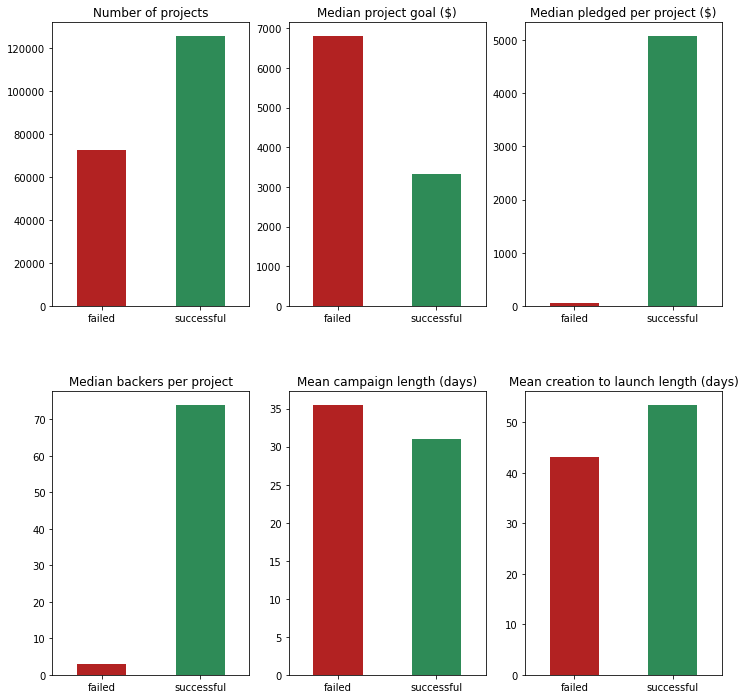

In [45]:
# Plotting the average amount pledged to successful and unsuccesful projects
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,12))

df['state'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

df.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

df.groupby('state').campaign_days.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

df.groupby('state').creation_to_launch_days.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean creation to launch length (days)')
ax6.set_xlabel('')

# df.groupby('state').name_length.mean().plot(kind='bar', ax=ax7, color=['firebrick', 'seagreen'], rot=0)
# ax7.set_title('Mean name length (words)')
# ax7.set_xlabel('')

# df.groupby('state').blurb_length.mean().plot(kind='bar', ax=ax8, color=['firebrick', 'seagreen'], rot=0)
# ax8.set_title('Mean blurb length (words)')
# ax8.set_xlabel('')

# # Creating a dataframe grouped by staff_pick with columns for failed and successful
# pick_df = pd.get_dummies(df.set_index('staff_pick').state).groupby('staff_pick').sum()
# # Normalizes counts by column, and selects the 'True' category (iloc[1])
# (pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0) 
# ax9.set_title('Proportion that are staff picks')
# ax9.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

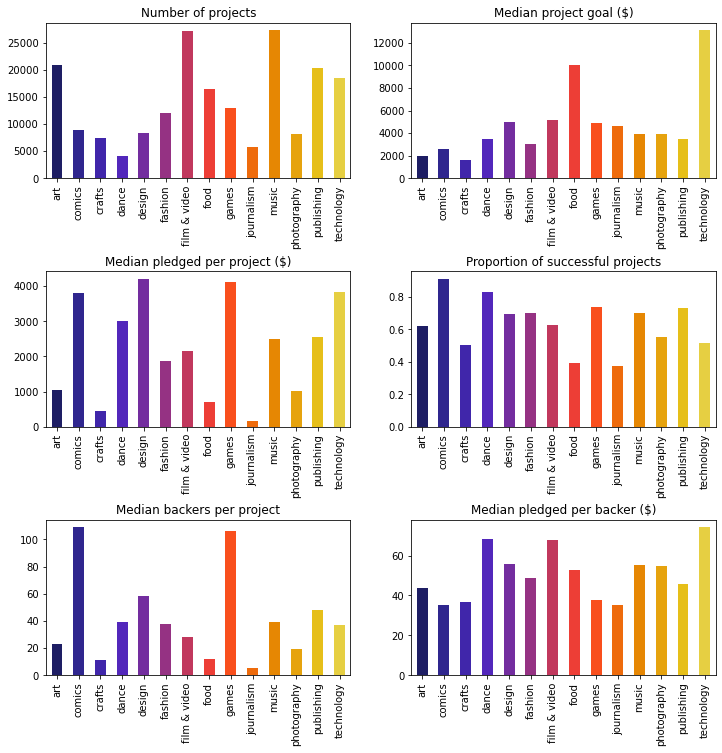

In [46]:
# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(df.set_index('category').state).groupby('category').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique())) # Setting a colormap

df.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('category').backers_count.median().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('category').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()

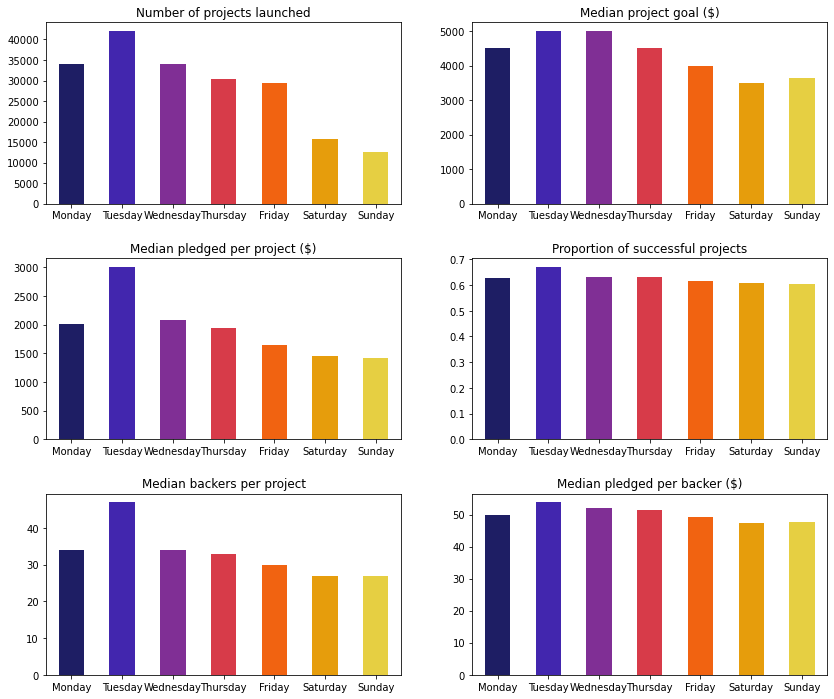

In [47]:
# Creating a dataframe grouped by the day on which they were launched, with columns for failed and successful
day_df = pd.get_dummies(df.set_index('launch_day').state).groupby('launch_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby('launch_day').launch_day.count().reindex(weekdays).plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')

df.groupby('launch_day').usd_goal.median().reindex(weekdays).plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('launch_day').usd_pledged.median().reindex(weekdays).plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

day_df.div(day_df.sum(axis=1), axis=0).successful.reindex(weekdays).plot(kind='bar', ax=ax4, color=color, rot=0) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('launch_day').backers_count.median().reindex(weekdays).plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('launch_day').pledge_per_backer.median().reindex(weekdays).plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

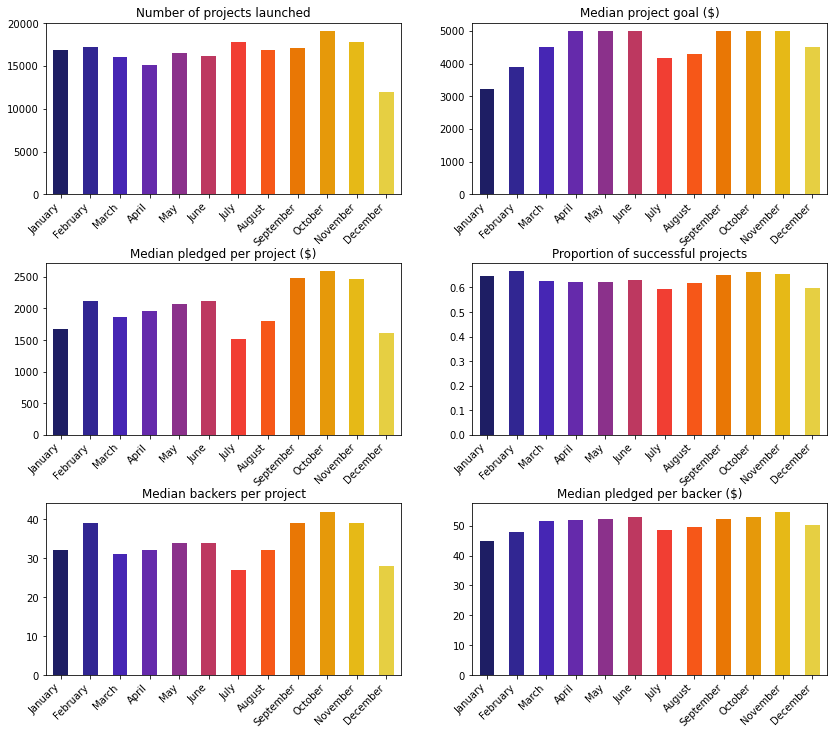

In [48]:
# Creating a dataframe grouped by the month in which they were launched, with columns for failed and successful
month_df = pd.get_dummies(df.set_index('launch_month').state).groupby('launch_month').sum()

# Plotting
months = list(calendar.month_name)[1:]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_month.nunique()))

df.groupby('launch_month').launch_month.count().reindex(months).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_goal.median().reindex(months).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_pledged.median().reindex(months).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

month_df.div(month_df.sum(axis=1), axis=0).successful.reindex(months).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_month').backers_count.median().reindex(months).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_month').pledge_per_backer.median().reindex(months).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.4)
plt.show()

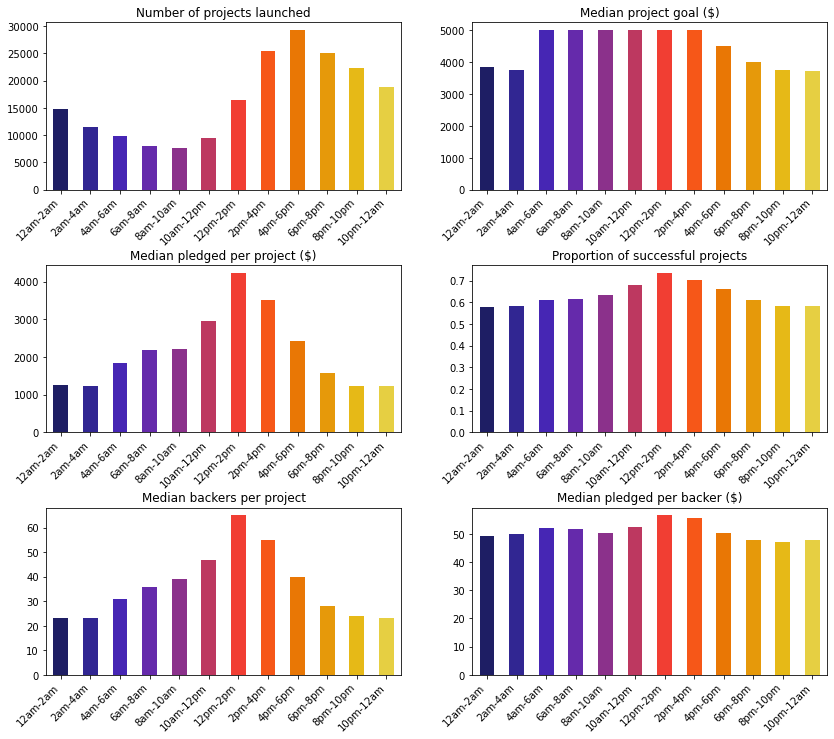

In [49]:
# Creating a dataframe grouped by the time at which they were launched, with columns for failed and successful
time_df = pd.get_dummies(df.set_index('launch_time').state).groupby('launch_time').sum()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_time.nunique()))

times = ['12am-2am', '2am-4am', '4am-6am', '6am-8am', '8am-10am', '10am-12pm', '12pm-2pm', '2pm-4pm', '4pm-6pm', '6pm-8pm', '8pm-10pm', '10pm-12am']

df.groupby('launch_time').launch_time.count().reindex(times).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_goal.median().reindex(times).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_pledged.median().reindex(times).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

time_df.div(time_df.sum(axis=1), axis=0).successful.reindex(times).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_time').backers_count.median().reindex(times).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_time').pledge_per_backer.median().reindex(times).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.45)
plt.show()

## class imbalance

In [50]:
df['state'].value_counts()

successful    125825
failed         72713
Name: state, dtype: int64

In [51]:
df_state_ = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

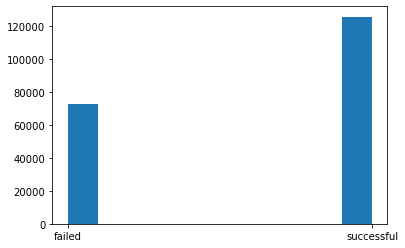

In [52]:
fig,ax=plt.subplots()
ax.hist(df_state_['state']);